In [3]:
import os
import yaml
import pandas as pd

# === CONFIGURATION ===
CSV_PATH = r"C:\GitHub\Android-Mobile-Apps\file_grouping_summary.csv"
#YAML_FOLDER = r"C:\Users\Admin\OneDrive\Education\Master of Info - Thesis\Config Files"
YAML_FOLDER = r"C:\Users\Parsazh\Downloads\Config Files-20250522T134837Z-1-001\Config Files"

# === KEYWORDS ===
EMULATOR_KEYWORDS = [ "emulator", "avdmanager", "adb", "instrumentation", "start emulator",
                      "create avd", "android-emulator", "run emulator", "wait-for-device"]
ANDROID_HINTS = ["android", "sdkmanager", "gradlew", "gradle", "build.gradle", "androidTest"]
CI_PROVIDERS = {
    'github': 'GitHub Actions',
    'travis': 'Travis CI',
    'circleci': 'CircleCI',
    'bitrise': 'Bitrise',
    'gitlab': 'GitLab CI'
}

# === LOAD GROUP FILE ===
df_group = pd.read_csv(CSV_PATH)
df_unparsed = df_group[df_group['group'] == 'not parsed or empty'].copy()

# === ANALYZE EACH FILE ===
analysis = []

for filepath in df_unparsed['file']:
    full_path = os.path.join(YAML_FOLDER, os.path.basename(filepath))
    result = {
        'file': full_path,
        'ci_provider': 'Unknown',
        'parsed_ok': False,
        'has_steps': False,
        'has_run': False,
        'has_android_keyword': False,
        'has_emulator_keyword': False
    }

    # service provider from filename
    path_lower = full_path.lower()
    for key, name in CI_PROVIDERS.items():
        if key in path_lower:
            result['ci_provider'] = name
            break

    # Try to load YAML safely
    try:
#        with open(full_path, 'r', encoding='utf-8') as f:
#            content = yaml.safe_load(f)
        with open(full_path, 'r', encoding='utf-8') as f:
            raw = f.read().replace('\t', ' ')  # Replace tabs with spaces
            content = yaml.safe_load(raw)
            if not content:
                analysis.append(result)
                continue

            result['parsed_ok'] = True
            content_str = yaml.dump(content).lower()

            # Check keywords in raw text
            result['has_emulator_keyword'] = any(k in content_str for k in EMULATOR_KEYWORDS)
            result['has_android_keyword'] = any(k in content_str for k in ANDROID_HINTS)

            # Check structural patterns
            if isinstance(content, dict):
                result['has_steps'] = 'steps' in content_str
                result['has_run'] = 'run' in content_str or 'script' in content_str

    except Exception:
        pass

    analysis.append(result)

# === OUTPUT RESULTS ===
df_analysis = pd.DataFrame(analysis)
output_path = r"C:\GitHub\Android-Mobile-Apps\not_parsed_analysis.csv"
df_analysis.to_csv(output_path, index=False)

print(f"Analysis complete. Saved to: {output_path}")


Analysis complete. Saved to: C:\GitHub\Android-Mobile-Apps\not_parsed_analysis.csv


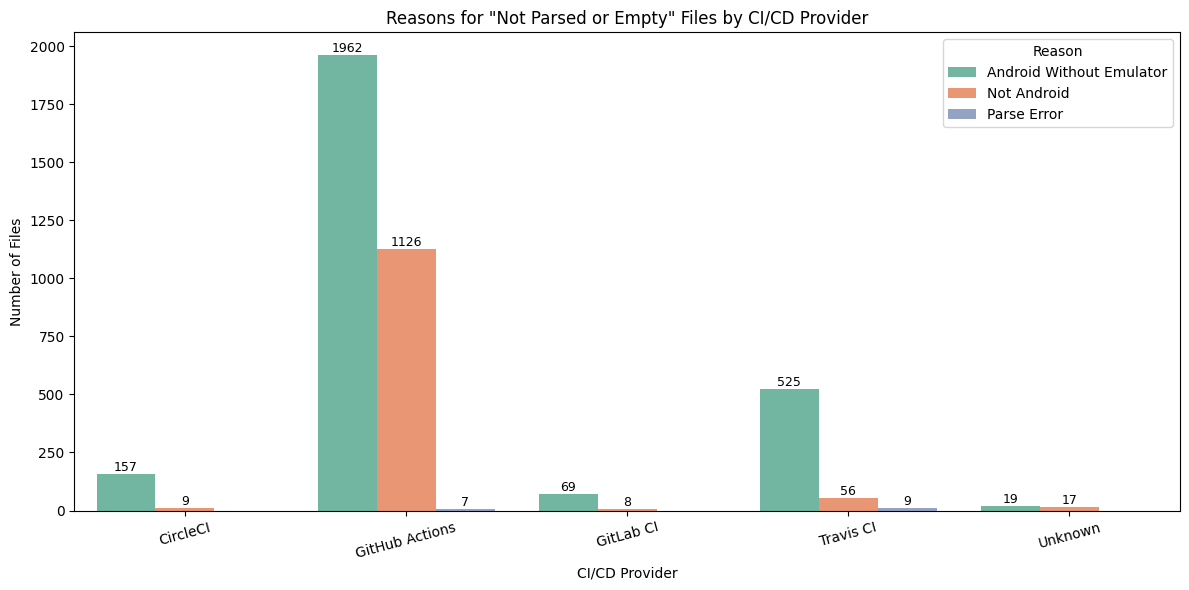

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load your analysis result (adjust path if needed)
csv_path = r"C:\GitHub\Android-Mobile-Apps\not_parsed_analysis.csv"
df = pd.read_csv(csv_path)

# === Classify the reason
def classify_reason(row):
    if not row['parsed_ok']:
        return 'Parse Error'
    elif row['has_android_keyword'] and not row['has_emulator_keyword']:
        return 'Android Without Emulator'
    elif not row['has_android_keyword']:
        return 'Not Android'
    else:
        return 'Other'

df['reason'] = df.apply(classify_reason, axis=1)

# === Aggregate data
summary = df.groupby(['ci_provider', 'reason']).size().reset_index(name='count')

# === Plot: Grouped Bar Chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=summary, x='ci_provider', y='count', hue='reason', palette='Set2')

# === Add data labels
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9)

# === Styling
plt.title('Reasons for "Not Parsed or Empty" Files by CI/CD Provider')
plt.xlabel('CI/CD Provider')
plt.ylabel('Number of Files')
plt.xticks(rotation=15)
plt.legend(title='Reason')
plt.tight_layout()
plt.show()

